<a href="https://colab.research.google.com/github/kiranraou/Python-Projects/blob/main/DeepLearning_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN Model - Face Images Dataset**

**Problem Statement** 

*The Faces have been automatically registered so that the face is
more or less centred and occupies about the same amount of space 
in each image. The task is to categorize each face based on the 
emotion shown in the facial expression into one of seven categories 
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 
6=Neutral)*

**Dataset Description**

Dataset Path >  https://drive.google.com/file/d/1oLGjrOgx17ZPnHSu33MRCibxB-LXPbH1/view?usp=sharing

-->> *Total Images: The Dataset consists of 28,709 examples*

-->> *Fer.csv contains 2 columns, "Emotion " and "Pixels".*

-->> *The emotion column contains a numeric 
code ranging from 0 to 6, inclusive, for the emotion that is present in the image*

-->> *The pixels column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order.*

-->> *This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project.*


**Selecting Tensorflow v2 -- Applicable only for Google Colab**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Mounting Google Drive**

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


**Importing Dataset into DataFrame**

In [5]:
data = pd.read_csv(
    '/content/drive/MyDrive/NIT Warangal _Industry Project/fer2013.csv')

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [8]:
emotion_map = {0: 'Angry', 
               1: 'Digust', 
               2: 'Fear',
               3: 'Happy', 
               4: 'Sad', 
               5: 'Surprise', 
               6: 'Neutral'
              }

In [9]:
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


***Plotting graph**

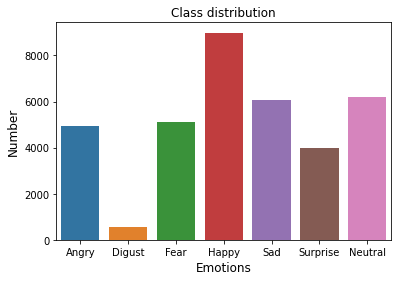

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

**Splitting data**

In [11]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()

print('Train data shape: {}, \n Validation data shape: {}, \nTest data shape: {}'.format(
    data_train.shape, data_val.shape, data_test.shape))

Train data shape: (28709, 3), 
 Validation data shape: (3589, 3), 
Test data shape: (3589, 3)


In [12]:
##Hyper-Parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 20
batch_size = 64
num_features = 64

**Converting,Reshaping,Normalizing and doing One-Hot encoding.

In [13]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, '_X shape: {}, ', dataName, '_Y shape: {}'.format(data_X.shape, data_Y.shape))
    return data_X, data_Y

# training data    
train_X, train_Y = CRNO(data_train, 'Train') 

# validation data
val_X, val_Y     = CRNO(data_val, 'Validation') 

# test data
test_X, test_Y   = CRNO(data_test, 'Test')

Train _X shape: {},  Train _Y shape: (28709, 48, 48, 1)
Validation _X shape: {},  Validation _Y shape: (3589, 48, 48, 1)
Test _X shape: {},  Test _Y shape: (3589, 48, 48, 1)


**Building CNN Model**

In [15]:
model = Sequential()

# module 1 - filter = num_features = 64
model.add(Conv2D(num_features, kernel_size=(
    5, 5), input_shape=(width, height, 1)))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 2 - filter = 2*num_features = 128
model.add(Conv2D(2*num_features, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 3 - filter = 2*2*num_features = 256
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

In [16]:
## Model Compilation ##

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, 
                             beta_1=0.9, 
                             beta_2=0.999, 
                             epsilon=1e-7),
              metrics=['accuracy'])


In [17]:
%%time
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)        102464    
_________________________________________________________________
batch_normalization_11 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)       

In [18]:
# data generator
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True)

In [19]:
# early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss', patience=10,
                   mode='min', restore_best_weights=True)

In [20]:

%%time
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                              steps_per_epoch=len(train_X) / batch_size,
                              epochs=num_epochs,
                              verbose=2,
                              callbacks=[es],
                              validation_data=(val_X, val_Y))


Epoch 1/20
 - 31s - loss: 1.6678 - accuracy: 0.3370 - val_loss: 1.7459 - val_accuracy: 0.2744
Epoch 2/20
 - 22s - loss: 1.3736 - accuracy: 0.4716 - val_loss: 1.5156 - val_accuracy: 0.4369
Epoch 3/20
 - 22s - loss: 1.2366 - accuracy: 0.5276 - val_loss: 1.1862 - val_accuracy: 0.5528
Epoch 4/20
 - 22s - loss: 1.1741 - accuracy: 0.5534 - val_loss: 1.3947 - val_accuracy: 0.4739
Epoch 5/20
 - 22s - loss: 1.1093 - accuracy: 0.5795 - val_loss: 1.1511 - val_accuracy: 0.5612
Epoch 6/20
 - 22s - loss: 1.0781 - accuracy: 0.5923 - val_loss: 1.0982 - val_accuracy: 0.5834
Epoch 7/20
 - 22s - loss: 1.0465 - accuracy: 0.6053 - val_loss: 1.1700 - val_accuracy: 0.5690
Epoch 8/20
 - 22s - loss: 1.0174 - accuracy: 0.6146 - val_loss: 1.1418 - val_accuracy: 0.5745
Epoch 9/20
 - 22s - loss: 0.9919 - accuracy: 0.6260 - val_loss: 1.0234 - val_accuracy: 0.6239
Epoch 10/20
 - 22s - loss: 0.9678 - accuracy: 0.6361 - val_loss: 1.0558 - val_accuracy: 0.6124
Epoch 11/20
 - 22s - loss: 0.9511 - accuracy: 0.6389 - val

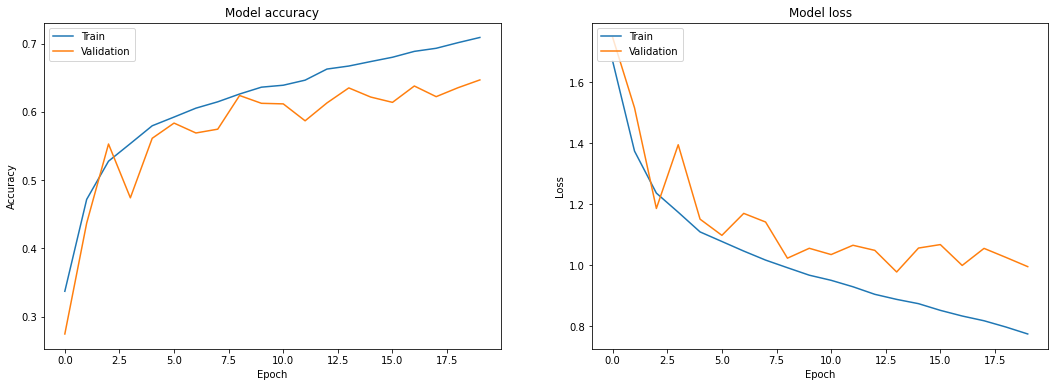

In [21]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
##Evaluate Test Performance
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)

print('CNN Model Accuracy on test set: {:.4f}'.format(
    accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6486


In [23]:
##Analysis using Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, Without Normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Labels',
           xlabel='Predicted Labels')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

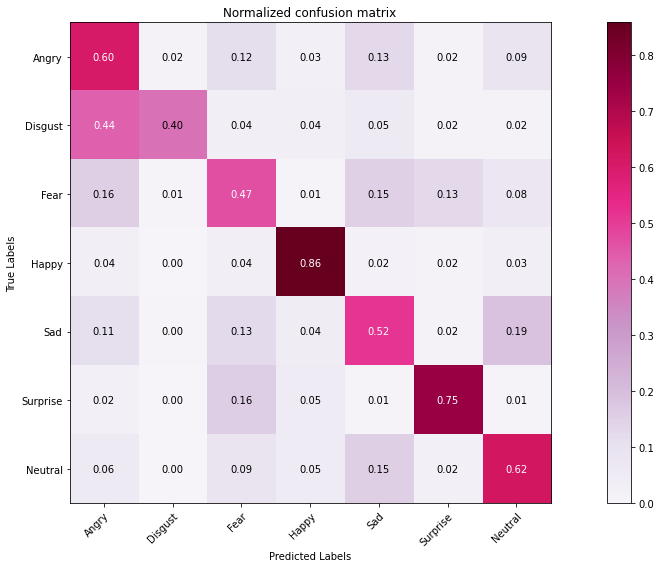

In [24]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True, title='Normalized confusion matrix')

plt.show()

**Saving the Model in Google Drive**

In [25]:
from keras.models import model_from_json

model_json = model.to_json()

with open('/content/drive/MyDrive/NIT Warangal _Industry Project/fer2013model.json', 'w') as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(
    '/content/drive/MyDrive/NIT Warangal _Industry Project/fer2013model.h5')

print('Saved model to disk')

Saved model to disk


In [45]:
##Converting the model to .pb file

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    
    with graph.as_default():
        
        freeze_var_names = list(
            set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [46]:
# Save Keras model as Tensorflow pb file
from keras import backend as K

# Create, compile and train model...
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, '/content/drive/MyDrive/NIT Warangal _Industry Project/', 'fer2013model.pb', 
                     as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 233 variables.
INFO:tensorflow:Converted 233 variables to const ops.


'/content/drive/MyDrive/NIT Warangal _Industry Project/fer2013model.pb'